In [9]:
# Import all libraries
import re
import networkx as nx
import matplotlib.pyplot as plt
import csv
import numpy as np
from scipy import stats
import matplotlib as mpl

In [10]:
# Get top players from peak_ratings.csv, store the variations in varNameMapping
def get_top_players(filepath, varNameMapping):

    with open(filepath, 'r', encoding="utf-8", errors="replace") as file:
        top_players = []
        file.readline() # header line skip
        for line in file:
            line_variations = []
            name = line.strip().split(",")[0]
            location = line.strip().split(",")[1].strip()
            parts = name.strip().split(" ")
            line_variations.append(name)
            line_variations.append(parts[1] + ", " + parts[0])
            line_variations.append(parts[0] + ", " + parts[1])
            line_variations.append(parts[1] + ", " + parts[0][0])
            line_variations.append(parts[0] + ", " + parts[1][0])
            line_variations.append(parts[1] + ", " + parts[0][0] + ".")
            line_variations.append(parts[0] + ", " + parts[1][0] + ".")
            line_variations.append(parts[1] + "," + parts[0])
            line_variations.append(parts[0] + "," + parts[1])
            line_variations.append(parts[1] + "," + parts[0][0])
            line_variations.append(parts[0] + "," + parts[1][0])
            line_variations.append(parts[1] + "," + parts[0][0] + ".")
            line_variations.append(parts[0] + "," + parts[1][0] + ".")
            # line_variations.append(parts[0])
            # line_variations.append(parts[1])

            for var in line_variations:
                varNameMapping[var] = (name, location)

            top_players.append(line_variations)
    return top_players


varNameMapping = {}
top_players = get_top_players("peak_ratings.csv", varNameMapping)
top_players_flattened = set()
for player in top_players:
    for variation in player:
        top_players_flattened.add(variation)

In [11]:
# Read through the .pgn file, get the games for top_players
def parse_pgn_headers(filepath, top_players):

    games = []
    with open(filepath, 'r', encoding="utf-8", errors="replace") as file:
        game_headers = {}
        for line in file:
            line = line.strip()
            if (line.startswith('[')):
                m = re.match(r'\[(\w+)\s+"(.*)"\]', line)
                if (m):
                    key, value = m.groups()
                    game_headers[key] = value
            elif (line == ""):
                if (game_headers):
                    if(game_headers["White"] in top_players and game_headers["Black"] in top_players):
                        games.append(game_headers)
                    game_headers = {}
        if game_headers:
            if(game_headers["White"] in top_players and game_headers["Black"] in top_players):
                games.append(game_headers)
    return games

games = parse_pgn_headers("chessabc_base.pgn", top_players_flattened)
print(f"Parsed {len(games)} games")

Parsed 45707 games


In [12]:
#Build the network using the games
def build_player_graph(games, top_players_flattened, varNameMapping):

    G = nx.DiGraph()
    for headers in games:
        event = headers.get("Event", "Unknown")
        site = headers.get("Site", "Unknown")
        date = headers.get("Date", "Unknown")
        white = headers.get("White", "Unknown")
        black = headers.get("Black", "Unknown")
        result = headers.get("Result", "Unknown")
        whiteElo = headers.get("WhiteElo", "0")
        blackElo = headers.get("BlackElo", "0")
        whiteFideId = headers.get("WhiteFideId", "0")
        blackFideId = headers.get("BlackFideId", "0")

        # Check if node exists, if it does update the elo and the date
        if (white not in G):
            if (white in top_players_flattened):
                white = varNameMapping[white][0]
                if (white not in G):
                    G.add_node(white, fideId=whiteFideId, elo=whiteElo, top_player=True, location=varNameMapping[white][1], lastGameDate=date)
                elif (not G.nodes[white].get("date") or date > G.nodes[white]["date"]):
                    G.nodes[white]["elo"] = whiteElo
                    G.nodes[white]["date"] = date
            else:
                G.add_node(white, fideId=whiteFideId, elo=whiteElo, top_player=False)
        if (black not in G):
            if (black in top_players_flattened):
                black = varNameMapping[black][0]
                if (black not in G):
                    G.add_node(black, fideId=blackFideId, elo=blackElo, top_player=True, location=varNameMapping[black][1], lastGameDate=date)
                elif (not G.nodes[black].get("date") or date > G.nodes[black]["date"]):
                    G.nodes[black]["elo"] = blackElo
                    G.nodes[black]["date"] = date
            else:
                G.add_node(black, fideId=blackFideId, elo=blackElo, top_player=False)

        edge_data = {
            "event": event,
            "site": site,
            "date": date,
            "white": white,
            "black": black,
            "whiteElo": whiteElo,
            "blackElo": blackElo,
            "result": result
        }

        # Add the edges to the nw
        if (result == "1-0"):
            # White win
            G.add_edge(white, black, **edge_data)
        elif (result == "0-1"):
            # Black win
            G.add_edge(black, white, **edge_data)
        elif (result == "1/2-1/2"):
            # Tie
            G.add_edge(white, black, **edge_data)
            G.add_edge(black, white, **edge_data)
        else:
            # Unknown result
            print("unknown result")
            continue
    return G

G = build_player_graph(games, top_players_flattened, varNameMapping)
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

unknown result
unknown result
unknown result
Graph has 120 nodes and 8537 edges


Number of nodes:  120
Number of edges:  8537
Average degree:  142.28333333333333
Minimum degree:  1
Maximum degree:  211


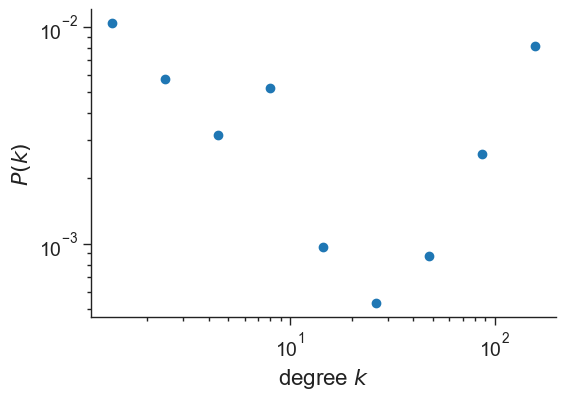

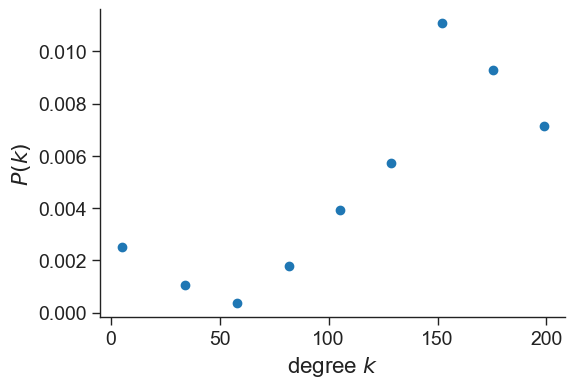

In [13]:
# Create visualaztions for the graph, for testing purposes
def visualize_graph(G):

    # change defaults to be less ugly
    mpl.rc('xtick', labelsize=14, color="#222222")
    mpl.rc('ytick', labelsize=14, color="#222222")
    mpl.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
    mpl.rc('font', size=16)
    mpl.rc('xtick.major', size=6, width=1)
    mpl.rc('xtick.minor', size=3, width=1)
    mpl.rc('ytick.major', size=6, width=1)
    mpl.rc('ytick.minor', size=3, width=1)
    mpl.rc('axes', linewidth=1, edgecolor="#222222", labelcolor="#222222")
    mpl.rc('text', usetex=False, color="#222222")

    N1 = len(G)
    L1 = G.size()
    degrees1 = [G.degree(node) for node in G]
    kmin1 = min(degrees1)
    kmax1 = max(degrees1)

    print("Number of nodes: ", N1)
    print("Number of edges: ", L1)
    print("Average degree: ", 2*L1/N1)
    print("Minimum degree: ", kmin1)
    print("Maximum degree: ", kmax1)

    # Log-log scale
    bin_edges1 = np.logspace(np.log10(kmin1), np.log10(kmax1), num=10)
    density1, _ = np.histogram(degrees1, bins=bin_edges1, density=True)
    fig1 = plt.figure(figsize=(6,4))
    log_be1 = np.log10(bin_edges1)
    x1 = 10**((log_be1[1:] + log_be1[:-1])/2)

    plt.loglog(x1, density1, marker='o', linestyle='none')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    plt.show()

    # Linear scale
    bin_edges1 = np.linspace(kmin1, kmax1, num=10)
    density1, _ = np.histogram(degrees1, bins=bin_edges1, density=True)
    x1 = (bin_edges1[1:] + bin_edges1[:-1])/2

    fig = plt.figure(figsize=(6,4))

    log_be1 = np.log10(bin_edges1)
    x1 = 10**((log_be1[1:] + log_be1[:-1])/2)

    plt.plot(x1, density1, marker='o', linestyle='none')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    plt.show()

visualize_graph(G)

In [14]:
# export the network into csv
def export_gephi_data(G, nodes_file, edges_file):

    with open(nodes_file, 'w', newline='', encoding='utf-8') as n_file:
        writer = csv.writer(n_file)
        writer.writerow(["Id", "Label", "fideId", "elo", "top_player", "location"])
        for node, data in G.nodes(data=True):
            writer.writerow([node, node, data.get("fideId", ""), data.get("elo", ""), data.get("top_player", ""), data.get("location", "")])

    with open(edges_file, 'w', newline='', encoding='utf-8') as e_file:
        writer = csv.writer(e_file)
        writer.writerow(["Source", "Target", "weight", "event", "site", "date", "white", "black", "whiteElo", "blackElo", "result"])
        for first, second, data in G.edges(data=True):
            writer.writerow([
                first, second, data.get("weight", 1), data.get("event", ""),
                data.get("site", ""), data.get("date", ""), data.get("white", ""),
                data.get("black", ""), data.get("whiteElo", ""), data.get("blackElo", ""),
                data.get("result", "")
            ])


nodes_file = "nodes_gephi.csv"
edges_file = "edges_gephi.csv"
export_gephi_data(G, nodes_file, edges_file)
print(f"Exported Gephi nodes to: {nodes_file}")
print(f"Exported Gephi edges to: {edges_file}")


Exported Gephi nodes to: nodes_gephi.csv
Exported Gephi edges to: edges_gephi.csv


Player: Hikaru Nakamura, Actual Elo: 2743, Artificial Elo: 2672.282834239725, winrate: 0.32, Draw rate: 0.48, Loss rate: 0.21
Player: Levon Aronian, Actual Elo: 2723, Artificial Elo: 2694.1628646867607, winrate: 0.24, Draw rate: 0.62, Loss rate: 0.15
Player: Ian Nepomniachtchi, Actual Elo: 2771, Artificial Elo: 2707.5422164630395, winrate: 0.35, Draw rate: 0.43, Loss rate: 0.21
Player: Dmitry Jakovenko, Actual Elo: 2698, Artificial Elo: 2712.6580843864167, winrate: 0.27, Draw rate: 0.58, Loss rate: 0.15
Player: Igor Kovalenko, Actual Elo: 2674, Artificial Elo: 2645.2674068965193, winrate: 0.35, Draw rate: 0.27, Loss rate: 0.39
Player: Vladimir Malakhov, Actual Elo: 2646, Artificial Elo: 2624.9414213027353, winrate: 0.25, Draw rate: 0.51, Loss rate: 0.24
Player: Alexander Riazantsev, Actual Elo: 2616, Artificial Elo: 2649.600604771934, winrate: 0.19, Draw rate: 0.50, Loss rate: 0.32
Player: Alexey Dreev, Actual Elo: 2606, Artificial Elo: 2656.2245041936226, winrate: 0.22, Draw rate: 0.5

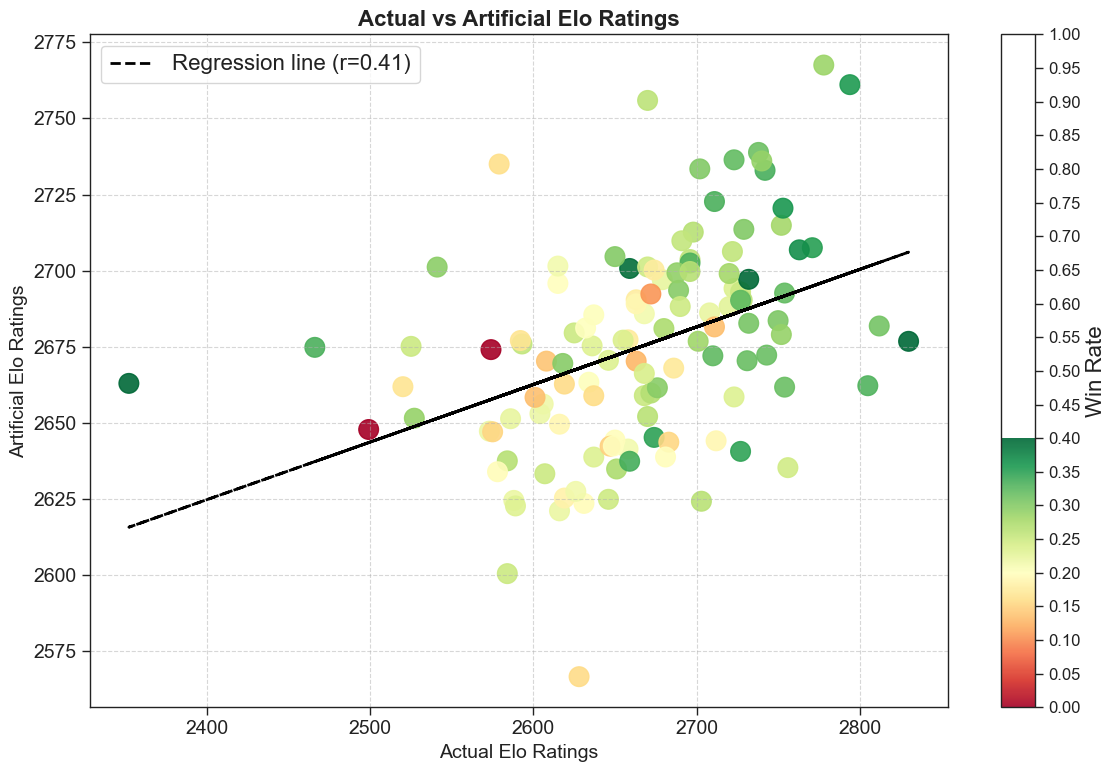

In [15]:
# rating change based on elo system
def update_elo(elo_ratings, player_one, player_two, result, k=32):
    Ra = elo_ratings[player_one]
    Rb = elo_ratings[player_two]

    Ea = 1 / (1 + 10 ** ((Rb - Ra) / 400))
    Eb = 1 - Ea

    if (result == "1-0"):
        Sa, Sb = 1, 0
    elif (result == "0-1"):
        Sa, Sb = 0, 1
    elif (result == "1/2-1/2"):
        Sa, Sb = 0.5, 0.5
    else:
        return

    elo_ratings[player_one] += k * (Sa - Ea)
    elo_ratings[player_two] += k * (Sb - Eb)

# simulate games, calcualte artificial rating, visualize in plot
def calculate_artificial_rating(G):
    initial_rating = 2675  # base Elo rating due to the constraint of top players
    elo_ratings = {player: initial_rating for player in G.nodes()}
    games = [(first, second, data) for first, second, data in G.edges(data=True)]
    games.sort(key=lambda x: x[2]["date"])

    in_degree_centrality = nx.in_degree_centrality(G)
    out_degree_centrality = nx.out_degree_centrality(G)

    for first, second, data in games:
        result = data['result']
        update_elo(elo_ratings, first, second, result, k=24)

    # Calculate win rates
    win_rates = {}
    for player in G.nodes():
        wins = draws = losses = 0

        for first, second, data in G.out_edges(player, data=True):
            result = data['result']
            if (result == "1/2-1/2"):
                # Each draw is counted twice, count half per edge
                draws += 0.5
            elif (data['white'] == player and result == "1-0") or \
                 (data['black'] == player and result == "0-1"):
                wins += 1

        for first, second, data in G.in_edges(player, data=True):
            result = data['result']
            if (result == "1/2-1/2"):
                draws += 0.5
            elif (data['white'] == player and result == "0-1") or \
                 (data['black'] == player and result == "1-0"):
                losses += 1

        total_games = wins + draws + losses
        win_rate = wins / total_games
        draw_rate = draws / total_games
        loss_rate = losses / total_games
        win_rates[player] = (win_rate, draw_rate, loss_rate)

    # Prepare data for scatter plot
    actual_elos = []
    artificial_elos = []
    wintare_vals = []
    in_degree_centrality_vals = []
    out_degree_centrality_vals = []
    player_names = []

    for player, data in G.nodes(data=True):
        actual_elo = int(data.get('elo', 0))
        artificial_elo = elo_ratings[player]
        winrate = win_rates[player]
        in_degree_centrality_player = in_degree_centrality[player]
        out_degree_centrality_player = out_degree_centrality[player]
        print(f"Player: {player}, Actual Elo: {actual_elo}, Artificial Elo: {artificial_elo}, winrate: {winrate[0]:.2f}, Draw rate: {winrate[1]:.2f}, Loss rate: {winrate[2]:.2f}")
        if (actual_elo > 0):  # Exclude players without a valid rating
            actual_elos.append(actual_elo)
            artificial_elos.append(artificial_elo)
            wintare_vals.append(winrate[0])
            player_names.append(player)
            in_degree_centrality_vals.append(in_degree_centrality_player)
            out_degree_centrality_vals.append(out_degree_centrality_player)

    plt.figure(figsize=(12, 8))

    scatter = plt.scatter(
        actual_elos,
        artificial_elos,
        c=wintare_vals,
        cmap='RdYlGn',
        s=200,
        alpha=0.9,
        vmin=0.0, # color scale
        vmax=0.4, # color scale
    )

    slope, intercept, r_value, p_value, std_err = stats.linregress(actual_elos, artificial_elos)
    plt.plot(
        actual_elos,
        intercept + slope * np.array(actual_elos),
        'k--',
        linewidth=2,
        label=f'Regression line (r={r_value:.2f})'
    )

    plt.xlabel('Actual Elo Ratings', fontsize=14)
    plt.ylabel('Artificial Elo Ratings', fontsize=14)
    plt.title('Actual vs Artificial Elo Ratings', fontsize=16, fontweight='bold')

    cbar = plt.colorbar(scatter, label='Win Rate')
    cbar.set_ticks(np.arange(0, 1.01, 0.05))
    cbar.ax.tick_params(labelsize=12)

    print("Pearson correlation coefficient:", r_value)


    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()




calculate_artificial_rating(G)

In [16]:
# NULL MODEL
num_null_models = 1000

clustering_list = []
path_length_list = []
num_strongly_connected_components_list = []
num_weakly_connected_components_list = []
assortativity_list = []
largest_scc_list = []
largest_wcc_list = []


in_deg_sequence = [d for n, d in G.in_degree()]
out_deg_sequence = [d for n, d in G.out_degree()]

for i in range(num_null_models):
    # Generate null model network
    null_model = nx.directed_configuration_model(in_deg_sequence, out_deg_sequence, create_using=nx.DiGraph())


    num_strong = nx.number_strongly_connected_components(G)
    num_strongly_connected_components_list.append(num_strong)
    num_weak = nx.number_weakly_connected_components(G)
    num_weakly_connected_components_list.append(num_weak)

    largest_scc = max(nx.strongly_connected_components(G), key=len)
    largest_scc_list.append(len(largest_scc))

    largest_wcc = max(nx.weakly_connected_components(G), key=len)
    largest_wcc_list.append(len(largest_wcc))

    assortativity = nx.degree_assortativity_coefficient(G)
    assortativity_list.append(assortativity)

    clustering = nx.average_clustering(null_model)
    clustering_list.append(clustering)

    if nx.is_strongly_connected(null_model):
        path_length = nx.average_shortest_path_length(null_model)
    else:
        largest_scc = max(nx.strongly_connected_components(null_model), key=len)
        subgraph = null_model.subgraph(largest_scc)
        path_length = nx.average_shortest_path_length(subgraph)
    path_length_list.append(path_length)

# Compute ensemble stats
clustering_mean = np.mean(clustering_list)
clustering_std = np.std(clustering_list)

path_length_mean = np.mean(path_length_list)
path_length_std = np.std(path_length_list)

num_strongly_connected_components_mean = np.mean(num_strongly_connected_components_list)
num_strongly_connected_components_std = np.std(num_strongly_connected_components_list)

num_weakly_connected_components_mean = np.mean(num_weakly_connected_components_list)
num_weakly_connected_components_std = np.std(num_weakly_connected_components_list)

assortativity_mean = np.mean(assortativity_list)
assortativity_std = np.std(assortativity_list)

largest_scc_mean = np.mean(largest_scc_list)
largest_scc_std = np.std(largest_scc_list)

largest_wcc_mean = np.mean(largest_wcc_list)
largest_wcc_std = np.std(largest_wcc_list)

# Print
print(f"Number of strongly connected components (null model): {num_strongly_connected_components_mean:.2f} ± {num_strongly_connected_components_std:.2f}")
print(f"Number of weakly connected components (null model): {num_weakly_connected_components_mean:.2f} ± {num_weakly_connected_components_std:.2f}")
print(f"Size of largest strongly connected component (null model): {largest_scc_mean:.2f} ± {largest_scc_std:.2f}")
print(f"Size of largest weakly connected component (null model): {largest_wcc_mean:.2f} ± {largest_wcc_std:.2f}")
print(f"Assortativity (null model): {assortativity_mean:.4f} ± {assortativity_std:.4f}")
print(f"Clustering coefficient (null model): {clustering_mean:.4f} ± {clustering_std:.4f}")
print(f"Path length (null model): {path_length_mean:.2f} ± {path_length_std:.2f}")

Number of strongly connected components (null model): 2.00 ± 0.00
Number of weakly connected components (null model): 1.00 ± 0.00
Size of largest strongly connected component (null model): 119.00 ± 0.00
Size of largest weakly connected component (null model): 120.00 ± 0.00
Assortativity (null model): -0.0507 ± 0.0000
Clustering coefficient (null model): 0.5015 ± 0.0046
Path length (null model): 1.59 ± 0.00


In [17]:
# REAL GRAHP
num_strong = nx.number_strongly_connected_components(G)
num_weak = nx.number_weakly_connected_components(G)

print(f"Number of strongly connected components: {num_strong}")
print(f"Number of weakly connected components: {num_weak}")

clustering_coeff = nx.average_clustering(G.to_undirected())
print(f"Average clustering coefficient: {clustering_coeff:.4f}")

assortativity = nx.degree_assortativity_coefficient(G)

print(f"Degree assortativity coefficient: {assortativity:.4f}")

if (nx.is_strongly_connected(G)):
    avg_path_length = nx.average_shortest_path_length(G)
else:
    largest_scc = max(nx.strongly_connected_components(G), key=len)
    subgraph = G.subgraph(largest_scc)
    avg_path_length = nx.average_shortest_path_length(subgraph)

print(f"Average shortest path length: {avg_path_length:.2f}")


Number of strongly connected components: 2
Number of weakly connected components: 1
Average clustering coefficient: 0.7975
Degree assortativity coefficient: -0.0507
Average shortest path length: 1.41


In [18]:

num_strong = nx.number_strongly_connected_components(G)
print(f"Number of strongly connected components: {num_strong}")


num_weak = nx.number_weakly_connected_components(G)
print(f"Number of weakly connected components: {num_weak}")


largest_scc = max(nx.strongly_connected_components(G), key=len)
print(f"Size of largest SCC: {len(largest_scc)}")


largest_wcc = max(nx.weakly_connected_components(G), key=len)
print(f"Size of largest WCC: {len(largest_wcc)}")

Number of strongly connected components: 2
Number of weakly connected components: 1
Size of largest SCC: 119
Size of largest WCC: 120


Player: Hikaru Nakamura, Actual Elo: 2743, Artificial Elo: 2685.2101629084327, winrate: 0.32, Draw rate: 0.48, Loss rate: 0.21
Player: Levon Aronian, Actual Elo: 2723, Artificial Elo: 2685.7715054650284, winrate: 0.24, Draw rate: 0.62, Loss rate: 0.15
Player: Ian Nepomniachtchi, Actual Elo: 2771, Artificial Elo: 2679.846873454668, winrate: 0.35, Draw rate: 0.43, Loss rate: 0.21
Player: Dmitry Jakovenko, Actual Elo: 2698, Artificial Elo: 2701.047793264516, winrate: 0.27, Draw rate: 0.58, Loss rate: 0.15
Player: Igor Kovalenko, Actual Elo: 2674, Artificial Elo: 2644.4856895436287, winrate: 0.35, Draw rate: 0.27, Loss rate: 0.39
Player: Vladimir Malakhov, Actual Elo: 2646, Artificial Elo: 2699.4427938840117, winrate: 0.25, Draw rate: 0.51, Loss rate: 0.24
Player: Alexander Riazantsev, Actual Elo: 2616, Artificial Elo: 2645.231093411814, winrate: 0.19, Draw rate: 0.50, Loss rate: 0.32
Player: Alexey Dreev, Actual Elo: 2606, Artificial Elo: 2661.6491945538023, winrate: 0.22, Draw rate: 0.55

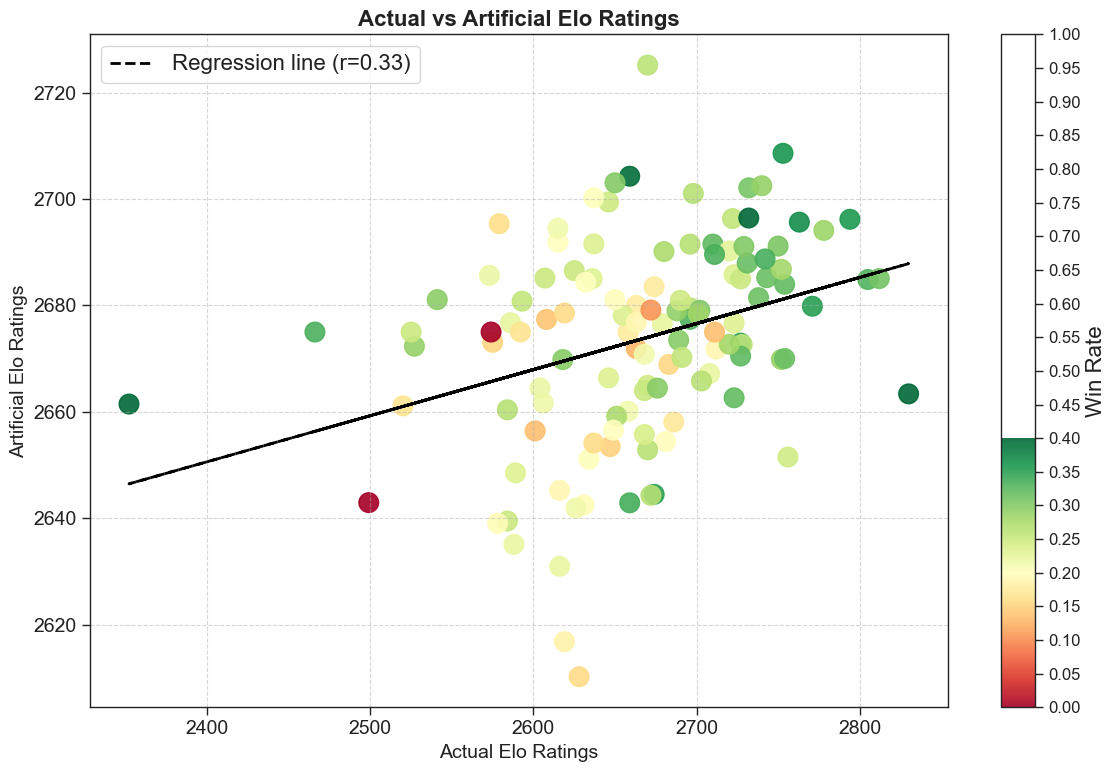

Player: Hikaru Nakamura, Glicko Rating: 2685.21, RD: 26.96, Volatility: 0.06
Player: Levon Aronian, Glicko Rating: 2685.77, RD: 23.40, Volatility: 0.06
Player: Ian Nepomniachtchi, Glicko Rating: 2679.85, RD: 23.98, Volatility: 0.06
Player: Dmitry Jakovenko, Glicko Rating: 2701.05, RD: 25.73, Volatility: 0.06
Player: Igor Kovalenko, Glicko Rating: 2644.49, RD: 27.85, Volatility: 0.06
Player: Vladimir Malakhov, Glicko Rating: 2699.44, RD: 25.87, Volatility: 0.06
Player: Alexander Riazantsev, Glicko Rating: 2645.23, RD: 25.73, Volatility: 0.06
Player: Alexey Dreev, Glicko Rating: 2661.65, RD: 30.83, Volatility: 0.06
Player: Sergey Karjakin, Glicko Rating: 2691.16, RD: 23.98, Volatility: 0.06
Player: Alexander Grischuk, Glicko Rating: 2702.11, RD: 23.15, Volatility: 0.06
Player: Alexander Morozevich, Glicko Rating: 2704.29, RD: 26.36, Volatility: 0.06
Player: Evgeny Najer, Glicko Rating: 2671.91, RD: 33.15, Volatility: 0.06
Player: Ni Hua, Glicko Rating: 2670.82, RD: 27.27, Volatility: 0.0

In [19]:
from glicko2 import Player as GlickoPlayer

#simulation for glicko-2
def calculate_glicko_ratings(G):
    #init glicko players
    glicko_players = {player: GlickoPlayer(rating=2675, rd=70, vol=0.06) for player in G.nodes()}
    games = [(first, second, data) for first, second, data in G.edges(data=True)]
    games.sort(key=lambda x: x[2]["date"])

    results = {player: {"opps": [], "rds": [], "scores": []} for player in G.nodes()}

    for first, second, data in games:
        result = data.get("result")
        if (result not in ["1-0", "0-1", "1/2-1/2"]):
            continue

        player_u = glicko_players[first]
        player_v = glicko_players[first]

        if (result == "1-0"):
            score_u, score_v = 1, 0
        elif (result == "0-1"):
            score_u, score_v = 0, 1
        else:
            score_u = score_v = 0.5

        results[first]["opps"].append(player_v.rating)
        results[first]["rds"].append(player_v.rd)
        results[first]["scores"].append(score_u)

        results[second]["opps"].append(player_u.rating)
        results[second]["rds"].append(player_u.rd)
        results[second]["scores"].append(score_v)

    for player, rec in results.items():
        if rec["opps"]:  # played games
            glicko_players[player].update_player(rec["opps"], rec["rds"], rec["scores"])

    final_ratings = {
        player: {
            "glicko_rating": glicko_players[player].rating,
            "rd": glicko_players[player].rd,
            "volatility": glicko_players[player].vol
        }
        for player in G.nodes()
    }

    # Calculate win rates
    win_rates = {}
    for player in G.nodes():
        wins = draws = losses = 0

        for first, second, data in G.out_edges(player, data=True):
            result = data['result']
            if (result == "1/2-1/2"):
                # Each draw is counted twice, count half per edge
                draws += 0.5
            elif (data['white'] == player and result == "1-0") or \
                 (data['black'] == player and result == "0-1"):
                wins += 1

        for first, second, data in G.in_edges(player, data=True):
            result = data['result']
            if (result == "1/2-1/2"):
                draws += 0.5
            elif (data['white'] == player and result == "0-1") or \
                 (data['black'] == player and result == "1-0"):
                losses += 1

        total_games = wins + draws + losses
        win_rate = wins / total_games if total_games > 0 else 0
        draw_rate = draws / total_games if total_games > 0 else 0
        loss_rate = losses / total_games if total_games > 0 else 0
        win_rates[player] = (win_rate, draw_rate, loss_rate)

    # Prepare data for scatter plot
    actual_elos = []
    artificial_elos = []
    wintare_vals = []
    in_degree_centrality_vals = []
    out_degree_centrality_vals = []
    player_names = []

    for player, data in G.nodes(data=True):
        actual_elo = int(data.get('elo', 0))
        artificial_elo = glicko_players[player].rating
        winrate = win_rates[player]
        print(f"Player: {player}, Actual Elo: {actual_elo}, Artificial Elo: {artificial_elo}, winrate: {winrate[0]:.2f}, Draw rate: {winrate[1]:.2f}, Loss rate: {winrate[2]:.2f}")
        if (actual_elo > 0):  # Exclude players without a valid rating
            actual_elos.append(actual_elo)
            artificial_elos.append(artificial_elo)
            wintare_vals.append(winrate[0])
            player_names.append(player)


    plt.figure(figsize=(12, 8))

    scatter = plt.scatter(
        actual_elos,
        artificial_elos,
        c=wintare_vals,
        cmap='RdYlGn',
        s=200,
        alpha=0.9,
        vmin=0.0, # color scale
        vmax=0.4, # color scale
    )

    slope, intercept, r_value, p_value, std_err = stats.linregress(actual_elos, artificial_elos)
    plt.plot(
        actual_elos,
        intercept + slope * np.array(actual_elos),
        'k--',
        linewidth=2,
        label=f'Regression line (r={r_value:.2f})'
    )

    plt.xlabel('Actual Elo Ratings', fontsize=14)
    plt.ylabel('Artificial Elo Ratings', fontsize=14)
    plt.title('Actual vs Artificial Elo Ratings', fontsize=16, fontweight='bold')


    cbar = plt.colorbar(scatter, label='Win Rate')
    cbar.set_ticks(np.arange(0, 1.01, 0.05))
    cbar.ax.tick_params(labelsize=12)

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return final_ratings

glicko_ratings = calculate_glicko_ratings(G)

# Print Glicko ratings
for player, data in glicko_ratings.items():
    print(f"Player: {player}, Glicko Rating: {data['glicko_rating']:.2f}, RD: {data['rd']:.2f}, Volatility: {data['volatility']:.2f}")
